#### Things to Try
1. Try directly train classifier without Language Model fine-tuning
    - Conditioned on a given text, generate texts with fine-tuned
    - Generate again WITHOUT fine-tuned
2. Try to recover the state (Databunch, partially trained model)
3. Check out how Language Model is trained (supervised? unsupervised?)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/userhome/34/h3509807/.fastai/data/imdb_sample/texts.csv')]

In [7]:
df = pd.read_csv(path / 'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


#### 0. Saving Intermediate Results

In [14]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [23]:
data_lm.save()

In [49]:
data = load_data(path)

#### 1. Tokenization

In [67]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')

In [65]:
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


#### 2. Numericalization

In [71]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [72]:
data.train_ds[0][0]

Text xxbos xxmaj why should you watch this ? xxmaj there are certainly no reasons why you should n't watch it ! xxmaj superbly and amusingly directed by xxmaj albert and xxmaj david xxmaj maysles , xxmaj grey xxmaj gardens was originally intended to be a film on the xxunk of xxmaj east xxmaj xxunk , but it turned out to the brothers that it would be more interesting to produce a study on the eccentric life of the two xxmaj edith xxmaj bouvier xxmaj beales , the aunt and cousin of xxmaj xxunk xxmaj kennedy xxmaj xxunk . xxmaj their life was certainly an amusing one ( xxmaj edith spent most of her day in bed singing xxunk , xxmaj edie xxunk xxunk and xxunk dances with their many cats , one was named xxmaj ted xxup xxunk xxmaj kennedy ) xxmaj the film is interesting because it is both funny and sad - xxmaj edith died shortly after the film was released ( in xxmaj xxunk 1977 ) aged 82 after experiencing some of the fame that she and xxmaj edie received after the film ( she xxunk and xxunk 

In [92]:
data.train_ds[0][0].data[:10]

array([  2,   5, 162, 150,  33, 120,  21,  68,   5,  55])

#### 3. Data Block API

In [102]:
data = (TextList.from_csv(path, 'texts.csv', cols = 'text')
                .split_from_df(col = 2)
                .label_from_df(cols = 0)
                .databunch()
       )

#### 4. Language Model

In [3]:
bs = 48
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/userhome/34/h3509807/.fastai/data/imdb/tmp_lm'),
 PosixPath('/userhome/34/h3509807/.fastai/data/imdb/test'),
 PosixPath('/userhome/34/h3509807/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/userhome/34/h3509807/.fastai/data/imdb/train'),
 PosixPath('/userhome/34/h3509807/.fastai/data/imdb/models'),
 PosixPath('/userhome/34/h3509807/.fastai/data/imdb/tmp_clas'),
 PosixPath('/userhome/34/h3509807/.fastai/data/imdb/unsup'),
 PosixPath('/userhome/34/h3509807/.fastai/data/imdb/README'),
 PosixPath('/userhome/34/h3509807/.fastai/data/imdb/imdb.vocab')]

In [4]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [5]:
data_lm.show_batch()

idx,text
0,"it 'll soon be 10 yrs since this movie was released xxrep 4 . still makes me laugh xxrep 4 . xxmaj if u enjoy this film , try the new xxmaj hera xxmaj pheri xxrep 4 . xxunk as hilarious . xxmaj and my favourite bit of the film must be when xxmaj salman realises that he has no bullets left in his gun while he has the upper"
1,this wonderful little film was . xxmaj director xxmaj griffin xxmaj dunne has done a great job assembling this film that has several characters and several story lines that blend so smoothly and seamlessly . xxmaj the main story involves the family and it is very thought - provoking and entertaining story that involved the viewer in every scene . xxmaj the film as a whole has credibility and integrity
2,"along with the disgusting scenes of violence of a horror movie ... the heroic feel of xxmaj princess xxmaj bride combined with the ( this is odd ) lack of any really good guys that xxmaj trainspotting had . \n \n i 'm not saying it was as xxup good as the xxmaj princess xxmaj bride , but it was in the arena , and it rocked . xxmaj"
3,"story is satisfying , and the entire cast is excellent - xxmaj chris xxmaj farley has never been better . xxmaj one of the very best comedies of the 90s . xxbos xxmaj this is really good . xxmaj original ideas in the film and a great terrorist action film . xxmaj only second to die hard and die hard with a vengeance , this film has suspense and a"
4,"remain out of bounds , but the walk along the xxmaj path of xxmaj illumination , now that 's almost free . \n \n xxmaj nothing new for those who have read the book other than to see it come alive , but for those who have n't , this film may just compel you to pick up xxmaj dan xxmaj brown 's novel just to read a bit"


In [6]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [170]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


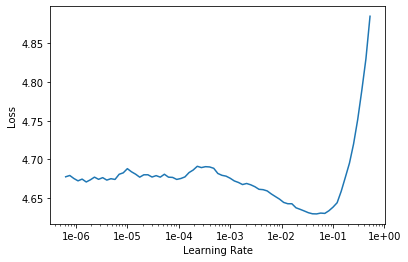

In [171]:
learn.recorder.plot(skip_end=15)

In [174]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.155055,4.015922,0.295924,26:33


In [175]:
learn.save('fit_head')

In [7]:
learn.load('fit_head');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.459061,4.375064,0.281552,26:31
1,4.056115,3.985936,0.309658,26:49
2,3.936169,3.864319,0.319501,26:44
3,3.849539,3.798418,0.325504,26:49


In [ ]:
learn.save('fine_tuned')
learn.load('fine_tuned');